In [49]:
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
data_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/Data/Raw_data/PUF AY %i/CSV/'
years = range(2017, 2023)
thoracotomy_codes = ['0WJB0ZZ', '0WJ90ZZ', '02JA0ZZ', '02JY0ZZ', '0BJL0ZZ', '0BJK0ZZ', '0BJQ0ZZ','0WJ80ZZ', '0WJC0ZZ', '0WJD0ZZ', '02VW0CZ', '02QA0ZZ', '3E080GC']
sternotomy_codes = ['0P800ZZ']

mechanism_code_dict = {1:'Cut/pierce', 2:'Drowning/submersion', 3:'Fall', 4:'Fire/flame', 5:'Hot object/substance', 6:'Firearm', 7:'Machinery', 8:'MVT Occupant', 9:'MVT Motorcyclist', 10:'MVT Pedal cyclist', 11:'MVT Pedestrian', 12:'MVT Unspecified', 13:'MVT Other', 14:'Pedal cyclist, other', 15:'Pedestrian, other', 16:'Transport, other', 17:'Natural/environmental,  Bites and stings', 18:'Natural/environmental,  Other', 19:'Overexertion', 20:'Poisoning', 21:'Struck by, against', 22:'Suffocation', 23:'Other specified and classifiable', 24:'Other specified, not elsewhere classifiable', 25:'Unspecified', 26:'Adverse effects, medical care', 27:'Adverse effects, drugs'} # As noted in PUF dictionary
trauma_type_code_dict = {1:'Blunt', 2:'Penetrating', 3:'Burn', 4:'Other/unspecified', 9:'Activity Code - Not Valid as a Primary E-Code'} # As noted in PUF Dictionary
sex_code_dict = {1:'Male', 2:'Female', 3:'Unknown'}
eddischarge_code_dict = {1: 'Floor bed (general admission, non-specialty unit bed)', 2: 'Observation unit (unit that provides < 24 hour stays)', 3: 'Telemetry/step-down unit (less acuity than ICU)', 4: 'Home with services', 5: 'Deceased/expired', 6: 'Other (jail, institutional care, mental health, etc.)', 7: 'Operating Room', 8: 'Intensive Care Unit (ICU)', 9: 'Home without services', 10: 'Left against medical advice', 11: 'Transferred to another hospital'}
hospdischarge_disposition_code_dict = {1: 'Discharged/Transferred to a short-term general hospital for inpatient care', 2: 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 3: 'Discharged/Transferred to home under care of organized home health service', 4: 'Left against medical advice or discontinued care', 5: 'Deceased/Expired', 6: 'Discharged to home or self-care (routine discharge)', 7: 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 8: 'Discharged/Transferred to hospice care', 10: 'Discharged/Transferred to court/law enforcement', 11: 'Discharged/Transferred to inpatient rehab or designated unit', 12: 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 13: 'Discharged/Transferred to a psychiatric hospital or psychiatric distinct part unit of a hospital', 14: 'Discharged/Transferred to another type of institution not defined elsewhere'}
deathined_code_dict = {1:'Arrived with NO signs of life', 2:'Arrived with signs of life'}
prehospca_code_dict = {1:'Yes', 2:'No'}
transport_mode_code_dict = {1:'Ground Ambulance', 2:'Helicopter Ambulance', 3:'Fixed-wing Ambulance', 4:'Private/Public Vehicle/Walk-in', 5:'Police', 6:'Other'}

cols17 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols19 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols17 = [x.upper() for x in cols17]
cols19 = [x.upper() for x in cols19]

common_cols = list(set(cols17) & set(cols19))

In [14]:
for year in years:
    
    if year in range(2017, 2019):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    elif year in range(2019, 2023):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    else:
        pass
    
    TRAUMA_df.columns = map(str.upper, TRAUMA_df.columns)
    ICDPROCEDURE_df.columns = map(str.upper, ICDPROCEDURE_df.columns)
    ICDPROCEDURE_LOOKUP_df.columns = map(str.upper, ICDPROCEDURE_LOOKUP_df.columns)
    ECODE_LOOKUP_df.columns = map(str.upper, ECODE_LOOKUP_df.columns)
    
    if year in range(2019, 2023):
        ICDPROCEDURE_df['PROCEDUREMINS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTHRS']*60
        ICDPROCEDURE_df['PROCEDUREDAYS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTDAYS']
        TRAUMA_df['HMRRHGCTRLSURGMINS'] = TRAUMA_df['HMRRHGCTRLSURGHRS']*60
    else:
        pass
    
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[:, ['INC_KEY', 'ICDPROCEDURECODE', 'PROCEDUREMINS', 'PROCEDUREDAYS']]
    
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'HMRRHGCTRLSURGMINS'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['HMRRHGCTRLSURGTYPE'] == 3.0]
    
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[ICDPROCEDURE_df['INC_KEY'].isin(np.unique(TRAUMA_df['INC_KEY']))]
    
    ICDPROCEDURE_LOOKUP_df = ICDPROCEDURE_LOOKUP_df.loc[:, ['ICDPROCEDURECODE', 'ICDPROCEDURECODE_DESC']]
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['INC_KEY'].isin(np.unique(ICDPROCEDURE_df['INC_KEY']))]
    
    TRAUMA_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLTRAUMA_df_%i.csv'%year, index=False)
    ICDPROCEDURE_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLICDPROCEDURE_df_%i.csv'%year, index=False)
    
    display(ICDPROCEDURE_df.head())
    display(TRAUMA_df.head())
    
    # Free up memory
    del TRAUMA_df, ICDPROCEDURE_df, ICDPROCEDURE_LOOKUP_df, ECODE_LOOKUP_df

,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
1050,170002937445,0BH17EZ,8.0,1.0
4010,170000021215,0W9930Z,NaN,NaN
4011,170000021215,0W9B30Z,NaN,NaN
4012,170000021215,0Y950ZZ,NaN,NaN
4013,170000021215,5A1221Z,NaN,NaN


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
251,NaN,1.0,2.0,NaN,NaN,1.0,33.0,0,0,0,...,103.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,2017.0
835,NaN,1.0,2.0,NaN,NaN,1.0,24.0,0,1,0,...,91.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,2017.0
1412,NaN,1.0,2.0,NaN,NaN,1.0,31.0,0,1,0,...,59.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,2017.0
1489,NaN,1.0,2.0,NaN,W74.XXXA,NaN,24.0,0,1,0,...,70.0,NaN,0,NaN,NaN,NaN,2.0,2.0,NaN,2017.0
1825,NaN,1.0,2.0,NaN,NaN,1.0,24.0,0,1,0,...,100.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,2017.0


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
2363,180023610118,BW40ZZZ,0.0,1.0
2364,180023610118,0BH17EZ,6.0,1.0
2366,180023610118,0W9930Z,10.0,1.0
2367,180023610118,0WJ90ZZ,29.0,1.0
2368,180023610118,02QA0ZZ,29.0,1.0


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
301,NaN,1.0,2.0,NaN,NaN,1.0,20.0,0,1,0,...,123.0,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,2018.0
1819,NaN,1.0,2.0,NaN,Y07.04,NaN,27.0,0,1,0,...,86.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,2018.0
2118,NaN,1.0,2.0,NaN,NaN,1.0,35.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,2018.0
3020,NaN,1.0,2.0,NaN,NaN,1.0,22.0,0,1,0,...,73.0,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
3257,NaN,1.0,2.0,NaN,NaN,1.0,71.0,0,1,0,...,NaN,2.0,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN


/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
1181,190027760890,BW03ZZZ,1.8,1.0
1309,190027760890,BN25ZZZ,24.0,1.0
1311,190027760890,BW40ZZZ,4.2,1.0
1313,190027760890,03HB33Z,49.8,1.0
1316,190027760890,0W9930Z,64.8,1.0


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
156,NaN,1.0,2.0,NaN,NaN,1.0,21.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
173,NaN,1.0,2.0,NaN,NaN,1.0,29.0,0,1,0,...,81.7,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
192,NaN,1.0,2.0,NaN,NaN,1.0,60.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1042,NaN,1.0,2.0,NaN,NaN,1.0,21.0,0,1,0,...,73.4,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
3316,NaN,1.0,2.0,NaN,NaN,1.0,26.0,0,1,0,...,92.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN


/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
2551,200042924891,NaN,NaN,NaN
10107,200043189429,03HY32Z,22.2,1.0
10108,200043189429,05H533Z,1561.2,2.0
10109,200043189429,0BBL0ZZ,343.8,1.0
10110,200043189429,0BH17EZ,142.8,1.0


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
504,NaN,NaN,NaN,NaN,NaN,NaN,23.0,0,1,0,...,100.0,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1459,NaN,NaN,NaN,NaN,NaN,NaN,89.0,1,0,0,...,80.0,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
3111,NaN,NaN,NaN,NaN,NaN,NaN,31.0,0,1,0,...,90.7,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
3214,NaN,NaN,NaN,NaN,NaN,NaN,37.0,0,0,0,...,NaN,2.0,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
3282,210057699044,02VW3DZ,771.0,2.0
3283,210057699044,03HB3DZ,625.8,2.0
3284,210057699044,08QNXZZ,NaN,2.0
3285,210057699044,0HQ1XZZ,NaN,2.0
3286,210057699044,0HQ1XZZ,NaN,2.0


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
414,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0,1,0,...,110.0,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
562,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1243,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0,0,0,...,NaN,2.0,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1695,NaN,NaN,NaN,NaN,NaN,NaN,29.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1714,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0,1,0,...,NaN,2.0,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS
4686,220063640246,0BH17EZ,3.0,1.0
4687,220063640246,0W9930Z,4.2,1.0
4688,220063640246,0W9B30Z,4.8,1.0
4689,220063640246,0WJ90ZZ,4.8,1.0
4690,220063640246,0WJB0ZZ,4.8,1.0


,ABUSEINVESTIGATION,ABUSEINVESTIGATION_BIU,ABUSEREPORT,ABUSEREPORT_BIU,ADDITIONALECODEICD10,ADDITIONALECODEICD10_BIU,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,...,WEIGHT,WEIGHT_BIU,WHITE,WITHDRAWALLST,WITHDRAWALLSTDAYS,WITHDRAWALLSTMINS,WITHDRAWALLST_BIU,WORKRELATED,WORKRELATED_BIU,YODISCH
736,NaN,NaN,NaN,NaN,NaN,NaN,58.0,0,1,0,...,85.00,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN
783,NaN,NaN,NaN,NaN,NaN,NaN,79.0,0,1,0,...,68.04,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1392,NaN,NaN,NaN,NaN,NaN,NaN,76.0,0,0,0,...,90.70,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1685,NaN,NaN,NaN,NaN,NaN,NaN,27.0,0,0,0,...,113.00,NaN,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN
1752,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0,1,0,...,115.00,NaN,0,2.0,NaN,NaN,NaN,2.0,NaN,NaN


In [38]:
TRAUMA_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLTRAUMA_df_%i.csv'
ICDPROCEDURE_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLICDPROCEDURE_df_%i.csv'

years = range(2017, 2023)

# Preload column names
TRAUMA_cols = pd.read_csv(TRAUMA_fp % 2017, nrows=1).columns.tolist()
ICDPROCEDURE_cols = pd.read_csv(ICDPROCEDURE_fp % 2017, nrows=1).columns.tolist()

# Collect DataFrames in lists
trauma_dfs = []
icdprocedure_dfs = []

for year in years:
    trauma_df = pd.read_csv(TRAUMA_fp % year, usecols=TRAUMA_cols)
    trauma_df['Year'] = year
    icdprocedure_df = pd.read_csv(ICDPROCEDURE_fp % year, usecols=ICDPROCEDURE_cols)
    icdprocedure_df['Year'] = year
    trauma_dfs.append(trauma_df)
    icdprocedure_dfs.append(icdprocedure_df)

# Concatenate DataFrames once at the end
TRAUMA_all_df = pd.concat(trauma_dfs, ignore_index=True)
ICDPROCEDURE_all_df = pd.concat(icdprocedure_dfs, ignore_index=True)

TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['HMRRHGCTRLSURGMINS'])
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['AGEYEARS'])
TRAUMA_all_df['HMRRHGCTRLSURGMINS'] = TRAUMA_all_df['HMRRHGCTRLSURGMINS'].round().astype(int)
TRAUMA_all_df = TRAUMA_all_df.loc[(TRAUMA_all_df['HMRRHGCTRLSURGMINS'] <= 20) & (TRAUMA_all_df['HMRRHGCTRLSURGDAYS'] <= 1.0)]
ICDPROCEDURE_all_df = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['INC_KEY'].isin(np.unique(TRAUMA_all_df['INC_KEY']))]

# Step 1: Drop rows that have NaN in both columns
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'], how='all')

# Step 2: Replace NaN values in one column with the value from the other column
TRAUMA_all_df['EDDISCHARGEDISPOSITION'] = TRAUMA_all_df['EDDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'])
TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['EDDISCHARGEDISPOSITION'])

# Step 3: Create the 'DECEASED' column
TRAUMA_all_df['DECEASED'] = 0  # Initialize with 0 (Survived)
TRAUMA_all_df.loc[(TRAUMA_all_df['EDDISCHARGEDISPOSITION'] == 5.0) | 
                  (TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] == 5.0), 'DECEASED'] = 1

# Step 4: Drop the 'EDDISCHARGEDISPOSITION' and 'HOSPDISCHARGEDISPOSITION' columns
TRAUMA_all_df = TRAUMA_all_df.drop(columns=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'INC_KEY'])

# Step 5: Calculate the threshold for 10% NaN values
threshold = len(TRAUMA_all_df) * 0.1

# Step 6: Drop columns with more than 10% NaN values
TRAUMA_all_df = TRAUMA_all_df.loc[:, TRAUMA_all_df.isna().sum() <= threshold]

# Step 7: Drop rows with any NaN values
TRAUMA_all_df= TRAUMA_all_df.dropna()

# Step 8: Remove columns ending in _BIU
TRAUMA_all_df = TRAUMA_all_df.drop(TRAUMA_all_df.filter(regex='_BIU$').columns, axis=1)

# Step 9: Convert strings to numbers

# Identify columns with string values
string_columns = TRAUMA_all_df.select_dtypes(include='object').columns

# Initialize a dictionary to store mapping dictionaries
mapping_dicts = {}

# Convert each unique string to an integer and create mapping dictionaries
for col in string_columns:
    unique_strings = TRAUMA_all_df[col].unique()
    string_to_int = {string: idx for idx, string in enumerate(unique_strings)}
    int_to_string = {idx: string for string, idx in string_to_int.items()}
    
    # Store the mapping dictionaries
    mapping_dicts[col] = {
        'string_to_int': string_to_int,
        'int_to_string': int_to_string
    }
    
    # Map the strings to integers in the DataFrame
    TRAUMA_all_df[col] = TRAUMA_all_df[col].map(string_to_int)

# Display results
display(TRAUMA_all_df.tail())
print(np.shape(TRAUMA_all_df))
display(ICDPROCEDURE_all_df.tail())
print(np.shape(ICDPROCEDURE_all_df))

# Free up memory
del trauma_dfs, icdprocedure_dfs

,AGEYEARS,AIRBAG_DEPLOYED_FRNT,AIRBAG_DEPLOYED_NA,AIRBAG_DEPLOYED_OTHER,AIRBAG_DEPLOYED_SIDE,AIRBAG_DEPLOYED_UK,AIRBAG_NOTDEPLOYED,ALCOHOLSCREEN,AMERICANINDIAN,ANGIOGRAPHY,...,TM_PRIVPUBVEHWALKIN,TM_UK,TOTALGCS,TRANSPORTMODE,VTEPROPHYLAXISTYPE,WHITE,WITHDRAWALLST,WORKRELATED,Year,DECEASED
17580,41.0,0,1,0,0,0,0,2.0,0,1.0,...,0,0,3.0,1.0,5.0,1,2.0,2.0,2022,1
17585,21.0,0,1,0,0,0,0,2.0,0,1.0,...,1,0,3.0,1.0,5.0,0,2.0,2.0,2022,1
17587,39.0,0,1,0,0,0,0,2.0,0,1.0,...,0,0,3.0,4.0,11.0,0,2.0,2.0,2022,0
17589,41.0,0,1,0,0,0,0,2.0,0,1.0,...,0,0,3.0,1.0,5.0,0,2.0,2.0,2022,1
17590,35.0,0,1,0,0,0,0,2.0,0,1.0,...,0,0,3.0,5.0,5.0,0,2.0,2.0,2022,1


(6516, 110)


,INC_KEY,ICDPROCEDURECODE,PROCEDUREMINS,PROCEDUREDAYS,Year
274140,220072330368,30233N1,7.2,1.0,2022
274141,220072330368,3E080GC,0.0,1.0,2022
274142,220072330368,5A12012,0.0,1.0,2022
274143,220072330368,5A1935Z,3.0,1.0,2022
274144,220072330368,BW40ZZZ,0.0,1.0,2022


(103042, 5)


In [41]:
print(np.unique(TRAUMA_all_df.dtypes))

[dtype('int64') dtype('float64')]


Alpha: 0.1
Training Accuracy: 0.954911742133538
Validation Accuracy: 0.950920245398773
Test Accuracy: 0.9524539877300614
Training Precision: 0.9638480392156863
Validation Precision: 0.9594155844155844
Test Precision: 0.9594155844155844
Training Recall: 0.987858488591166
Validation Recall: 0.9882943143812709
Test Recall: 0.9899497487437185
Training F1 Score: 0.9757055722113099
Validation F1 Score: 0.9736408566721582
Test F1 Score: 0.9744435284418795


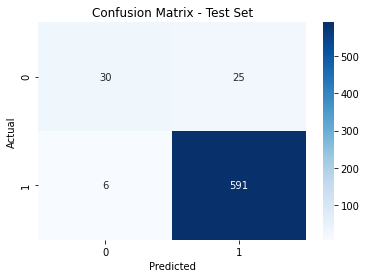

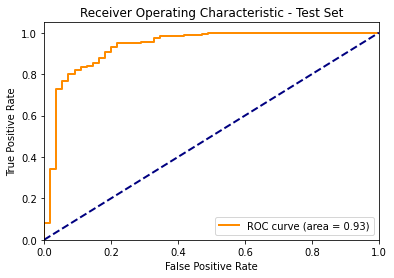

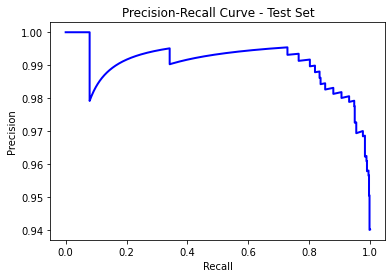

In [59]:
# Step 1: Split the data into 80% training and 20% remaining
train_df, remaining_df = train_test_split(
    TRAUMA_all_df, 
    test_size=0.2, 
    stratify=TRAUMA_all_df['DECEASED'], 
    random_state=42
)

# Step 2: Split the remaining data into 50% validation and 50% test
val_df, test_df = train_test_split(
    remaining_df, 
    test_size=0.5, 
    stratify=remaining_df['DECEASED'], 
    random_state=42
)

# Step 3: Split into X and y
X_train = train_df.drop(columns=['DECEASED'])
y_train = train_df['DECEASED']

X_val = val_df.drop(columns=['DECEASED'])
y_val = val_df['DECEASED']

X_test = test_df.drop(columns=['DECEASED'])
y_test = test_df['DECEASED']

def lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate a Lasso (L1) regularized logistic regression classifier with a given alpha value.
    
    Parameters:
    alpha (float): Regularization strength.
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training target.
    X_val (pd.DataFrame): Validation features.
    y_val (pd.Series): Validation target.
    X_test (pd.DataFrame): Test features.
    y_test (pd.Series): Test target.
    
    Returns:
    model (LogisticRegression): Trained logistic regression model.
    y_train_pred (np.ndarray): Predicted target values for training set.
    y_val_pred (np.ndarray): Predicted target values for validation set.
    y_test_pred (np.ndarray): Predicted target values for test set.
    y_train_proba (np.ndarray): Predicted probabilities for training set.
    y_val_proba (np.ndarray): Predicted probabilities for validation set.
    y_test_proba (np.ndarray): Predicted probabilities for test set.
    """
    # Initialize the Logistic Regression model with L1 regularization
    model = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear')
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the training, validation, and test sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Predict probabilities for ROC and Precision-Recall curves
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Print accuracy and other metrics for evaluation
    print(f"Alpha: {alpha}")
    print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"Training Precision: {precision_score(y_train, y_train_pred)}")
    print(f"Validation Precision: {precision_score(y_val, y_val_pred)}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred)}")
    print(f"Training Recall: {recall_score(y_train, y_train_pred)}")
    print(f"Validation Recall: {recall_score(y_val, y_val_pred)}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred)}")
    print(f"Training F1 Score: {f1_score(y_train, y_train_pred)}")
    print(f"Validation F1 Score: {f1_score(y_val, y_val_pred)}")
    print(f"Test F1 Score: {f1_score(y_test, y_test_pred)}")
    
    return model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba

alpha_value = 0.1
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba = lasso_classifier(alpha_value, X_train, y_train, X_val, y_val, X_test, y_test)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.show()

# Plot confusion matrix for test set
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

# Plot ROC curve for test set
plot_roc_curve(y_test, y_test_proba, 'Test Set')

# Plot Precision-Recall curve for test set
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')


# Pretty easy to predict mortality of thoracotomy without even fine tuning or doing anything complicated